# Train a BNN to classify MNIST

In [4]:
%load_ext autoreload
# Train a Bayesian neural network to classify MNIST using
# (parallel) Langevin dynamics
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
import sys
sys.path.append("../../learning_particle_gradients/")
sys.path.append("../../experiments/")
from functools import partial
from itertools import cycle

import numpy as onp
import jax
from jax import numpy as jnp
from jax import jit, grad, value_and_grad, vmap, pmap, config, random
config.update("jax_debug_nans", False)
from jax.ops import index_update, index
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import tensorflow_datasets as tfds

import haiku as hk
import optax

import metrics
import nets
import utils
from convnet import model, accuracy, crossentropy_loss, log_prior
import jax.flatten_util

import os
on_cluster = not os.getenv("HOME") == "/home/lauro"

# Config
key = random.PRNGKey(0)
EPOCHS = 1
BATCH_SIZE = 128
LEARNING_RATE = 1e-7
NUM_SAMPLES = 100
DISABLE_PROGRESS_BAR = False
USE_PMAP = False

if USE_PMAP: # TODO debug pmap
    vpmap = pmap
else:
    vpmap = vmap

# Load MNIST
data_dir = './data' if on_cluster else '/tmp/tfds'
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']

# Full train and test set
train_images, train_labels = train_data['image'], train_data['label']
test_images, test_labels = test_data['image'], test_data['label']

# Split off the validation set
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=0)
data_size = len(train_images)


def make_batches(images, labels, batch_size):
    """Returns an iterator that cycles through 
    tuples (image_batch, label_batch)."""
    num_batches = len(images) // batch_size
    split_idx = onp.arange(1, num_batches+1)*batch_size
    batches = zip(*[onp.split(data, split_idx, axis=0) for data in (images, labels)])
    return cycle(batches)


def loss(params, images, labels):
    """Minibatch approximation of the (unnormalized) Bayesian
    negative log-posterior evaluated at `params`. That is,
    -log model_likelihood(data_batch | params) * batch_rescaling_constant - log prior(params))"""
    logits = model.apply(params, images)
    return data_size/BATCH_SIZE * crossentropy_loss(logits, labels) - log_prior(params) 

opt = utils.sgld(LEARNING_RATE)

@jit
def step(param_set, opt_state, images, labels):
    """Update param_set elements in parallel using Langevin dynamics."""
    step_losses, g = vpmap(value_and_grad(loss), (0, None, None))(param_set, images, labels)
    g, opt_state = opt.update(g, opt_state, param_set)
    aux = {
        "losses": step_losses,
        "global_grad_norm": optax.global_norm(g), 
    }
    return optax.apply_updates(param_set, g), opt_state, aux


@jit
def ensemble_accuracy(param_set):
    """use ensemble predictions to compute validation accuracy"""
    vapply = vpmap(model.apply, (0, None))
    logits = vapply(param_set, val_images[:BATCH_SIZE])
    preds = jnp.mean(vmap(jax.nn.softmax)(logits), axis=0) # mean prediction
    return jnp.mean(preds.argmax(axis=1) == val_labels[:BATCH_SIZE])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training with parallel Langevin dynamics

In [5]:
# initialize set of parameters
key, subkey = random.split(key)
param_set = vmap(model.init, (0, None))(random.split(subkey, NUM_SAMPLES), train_images[:5])
opt_state = opt.init(param_set)

batches = make_batches(train_images, train_labels, BATCH_SIZE)
n_train_steps = EPOCHS * data_size // BATCH_SIZE

In [19]:
# training loop
n_train_steps = 100
rundata = {}
trajectories = []
accuracies = []
for step_counter in tqdm(range(n_train_steps), disable=DISABLE_PROGRESS_BAR):
    images, labels = next(batches)
    param_set, opt_state, aux = step(param_set, opt_state, images, labels)
    metrics.append_to_log(rundata, aux)
    trajectories.append(vmap(lambda ps: jax.flatten_util.ravel_pytree(ps)[0])(param_set))

    if step_counter % 5 == 0:
        accuracies.append(ensemble_accuracy(param_set))
#         print(f"Step {step_counter}, Accuracy:", accuracies[-1])

final_acc = ensemble_accuracy(param_set)
print(f"Final accuracy: {final_acc}")

100%|██████████| 100/100 [04:28<00:00,  2.68s/it]


Final accuracy: 0.5703125


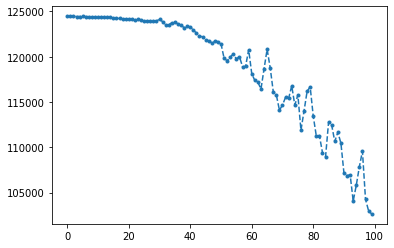

In [21]:
plt.plot(onp.array(rundata['losses']).mean(axis=1), "--.");

In [27]:
trajectories_arr = onp.array(trajectories)
print(trajectories_arr.shape)

(100, 100, 312)


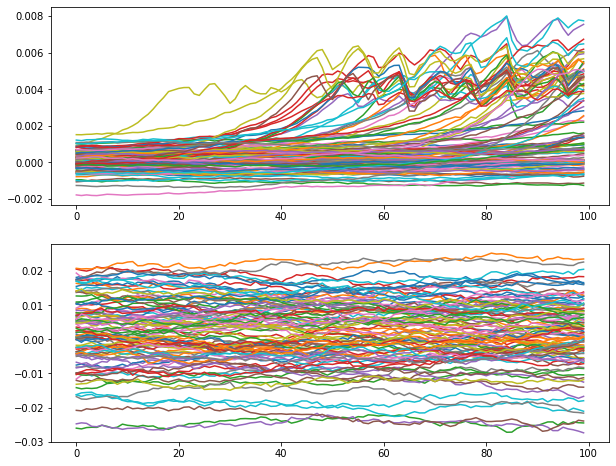

In [25]:
# visualize trajectory avg across dimensions (distinguish particles)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories_arr.mean(axis=2));  # avg across dims

ax = axs[1]
ax.plot(trajectories_arr[:, :, 0]);  # watch single param (aka single dimension)

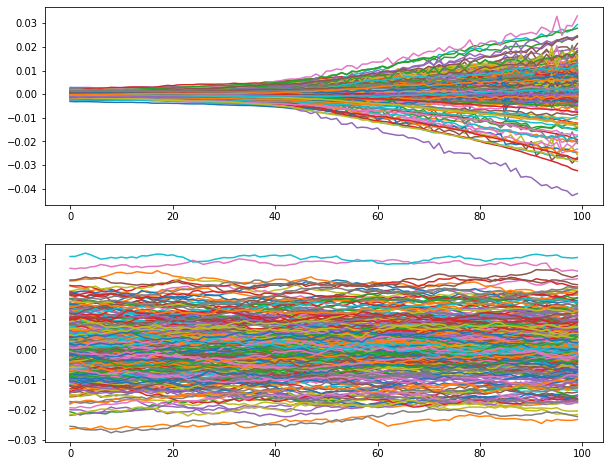

In [28]:
# visualize trajectory avg across particles (distinguish dims, ie parameters)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories_arr.mean(axis=1)); # avg across particles

ax = axs[1]
ax.plot(trajectories_arr[:, 10, :]); # watch single particle

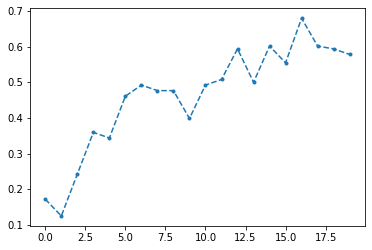

In [22]:
plt.plot(accuracies, "--.");

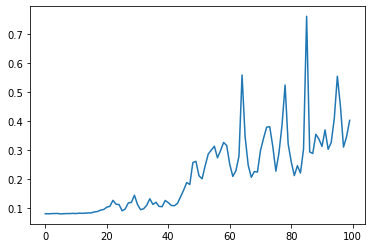

In [23]:
plt.plot(rundata['global_grad_norm'])

# Classic (non-Bayesian) training
* Train a classifier using SGD. 
* To be consistent with the BNN approach, all parameters (including biases) are initialized as $N(0, 1/100^2)$ (ie the prior).
* The training loss is $L^2$-regularized, corresponding roughly to the maximum a posteriori estimator with the normal prior.

Note: works fine with networks as small as 2-layer conv with 4 channels per layer (loss decreases steadily and accuracy is ~0.92 after two epochs).

In [ ]:
learning_rate = 1e-7
# opt = optax.sgd(learning_rate)
opt = utils.sgld(learning_rate)

@jit
def classic_step(params, opt_state, images, labels):
    step_loss, g = value_and_grad(loss)(params, images, labels)
    g, opt_state = opt.update(g, opt_state, params)
    return optax.apply_updates(params, g), opt_state, step_loss

@jit
def compute_accuracy(params):
    return accuracy(model.apply(params, val_images[:BATCH_SIZE]), val_labels[:BATCH_SIZE])


batches = make_batches(train_images, train_labels, BATCH_SIZE)
key, subkey = random.split(key)
params = model.init(subkey, train_images[:2])
opt_state = opt.init(params)

ls = []
ces = []
accs = []

In [ ]:
for step_count in tqdm(range(900)):
    images, labels = next(batches)
    params, opt_state, step_loss = classic_step(params, opt_state, images, labels)
    ls.append(step_loss)
#     ces.append(ce)

#     if step_count % 100 == 0:
#         current_acc = compute_accuracy(params)
#         accs.append(current_acc)
#         print(current_acc)

In [ ]:
# SGD, lr=1e-7
plt.plot(ls[:50])
print(compute_accuracy(params))